In [1]:
import pandas as pd
import ast,json
import numpy as np
from pymatgen.core import Composition
import CompositionDeformer as compd
from tensorflow.keras.utils import to_categorical
print("hello new materials")
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from tensorflow.keras.models import clone_model
from IPython.display import Image
import tqdm

hello new materials


In [26]:
print(ak.__version__)

1.0.5


In [2]:
# import materials project database
seeddata = pd.read_csv("./database/materials_project/mp_all_data.csv",index_col=0)
# add 1d periodic table array and normalized magnifications
normalized_magnifications = []
composition_names = []
normalized_compositions = []

for unit in tqdm.tqdm(seeddata["unit_cell_formula"]):
    compdict = ast.literal_eval(unit)
    composition_name = ""
    for item in compdict.items():
        composition_name += item[0] + str(item[1])
    #print(f"composition name: {composition_name}")
    composition_names.append(composition_name)
    #組成の規格化
    comp = Composition(composition_name)
    normalized_compositions.append(comp.fractional_composition.reduced_formula)
    ratio_list = {}
    for el,ratio in comp.fractional_composition.as_dict().items():
        ratio_list[el] = ratio
    #規格化後の倍率を取得
    normalized_magnification = [ratio_list[key]/compdict[key] for key in compdict.keys()][0]
    #print(f"normalized magnification: {normalized_magnification}")
    normalized_magnifications.append(normalized_magnification)

  8%|▊         | 10301/126335 [00:01<00:11, 10265.59it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
 10%|▉         | 12321/126335 [00:01<00:11, 10153.95it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
 37%|███▋      | 46516/126335 [00:04<00:07, 10329.42it/s]/home/wshogo/.local/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:426: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
100%|██████████| 126335/126335 [00:12<00

In [3]:
print(seeddata.keys())

Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry', 'is_hubbard', 'hubbards', 'is_compatible',
       'icsd_id', 'elasticity', 'piezo', 'diel', 'formation_energy_per_atom'],
      dtype='object')


In [4]:
for i in seeddata["icsd_id"][:100]:
    if i!="[]" :
        print(i)
print(seeddata["is_hubbard"][:100])

[182362]
[44702]
[190587]
[105158]
[184949]
[624028]
[430299]
[152794]
[602715]
[637438]
[23940]
[645257]
[632162]
[635163]
[74993]
[609079]
[50577]
[251000]
[252385, 252386, 195755]
[281423]
[616457, 58743]
[646985, 105428, 646996]
[164971]
[98974]
[23772]
[65686]
[658748]
[424468]
[657422]
[656291]
[623133]
[426888]
[194226]
[651293]
[1946, 30564, 23931, 633, 36153, 8042]
[239095]
[74951]
[617880]
[2243]
[88000]
[425115]
[428809]
[21023, 25326]
0     False
1     False
2     False
3      True
4      True
      ...  
95    False
96    False
97    False
98    False
99    False
Name: is_hubbard, Length: 100, dtype: bool


In [5]:
print(seeddata.keys())
##エネルギーを規格化しseeddataに追加
energy_array = np.array(seeddata["energy"],dtype=np.float32)
magnifications_array = np.array(normalized_magnifications,dtype=np.float32)
normalized_energy = energy_array*magnifications_array
seeddata["normalized_energy"] = normalized_energy
##normalized_magnificationを追記
seeddata["normalized_magnification"] = normalized_magnifications
##compositionを追記
seeddata["composition_name"] = composition_names
##normalized_compositionsを追記
seeddata["normalized_composition"] = normalized_compositions
print(seeddata.keys())

Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry', 'is_hubbard', 'hubbards', 'is_compatible',
       'icsd_id', 'elasticity', 'piezo', 'diel', 'formation_energy_per_atom'],
      dtype='object')
Index(['pretty_formula', 'unit_cell_formula', 'energy', 'energy_per_atom',
       'band_gap', 'symmetry', 'is_hubbard', 'hubbards', 'is_compatible',
       'icsd_id', 'elasticity', 'piezo', 'diel', 'formation_energy_per_atom',
       'normalized_energy', 'normalized_magnification', 'composition_name',
       'normalized_composition'],
      dtype='object')


In [7]:
#重複する組成データのうちエネルギーが最も低いもののみ残す
##エネルギー順に並び変え
sorted_seeddata = seeddata.sort_values(['normalized_composition','normalized_energy'])
print(sorted_seeddata.shape)
##重複した組成式のうち一番上（昇順なので一番上が最安定）のみ残して削除
dropped_seeddata = sorted_seeddata.drop_duplicates(keep='first',subset='normalized_composition')
##DFT + Uを使っている計算を排除
dropped_seeddata = dropped_seeddata[dropped_seeddata['is_hubbard'] != True]
##互換性のある計算のみ取得
dropped_seeddata = dropped_seeddata[dropped_seeddata['is_compatible'] != False]
print(dropped_seeddata.shape)
print(dropped_seeddata["is_hubbard"][:100])

(126335, 18)
(70961, 18)
32922     False
24167     False
3918      False
115907    False
99922     False
          ...  
60226     False
123179    False
45235     False
29188     False
54931     False
Name: is_hubbard, Length: 100, dtype: bool


In [8]:
#拡張周期表表記の入力配列を作成
periodic_1d_arrays = []
for composition_name in tqdm.tqdm(dropped_seeddata['normalized_composition']):
    periodic_1d_arrays.append(compd.generate_extended_PT_from_composition(composition_name).get_1d_array())
#入力データを2次元マップに変換
X = np.array(periodic_1d_arrays, dtype = np.float32)
X = X.reshape((len(X),7,32))
print(X.shape)

##バンドギャップをnumpy配列化
band_gap_array = np.array(dropped_seeddata["band_gap"],dtype=np.float32)
##空間群をcategorical配列に変換
symmetry_category = to_categorical(dropped_seeddata["symmetry"])
##formation_energy_per_atomをnumpy配列化
formation_energy_per_atom = np.array(dropped_seeddata["formation_energy_per_atom"],dtype=np.float32)

100%|██████████| 70961/70961 [00:03<00:00, 20041.54it/s]


(70961, 7, 32)


In [9]:
#訓練用データセットに分ける
from sklearn.model_selection import train_test_split
# X_train,X_test,bandgap_train,bandgap_test,symmetry_train,symmetry_test = train_test_split(X,band_gap_array,symmetry_category,test_size=0.1)
X_train,X_test,energy_train,energy_test,symmetry_train,symmetry_test,formation_train,formation_test = train_test_split(X,dropped_seeddata["normalized_energy"],symmetry_category,formation_energy_per_atom,test_size=0.1)

In [19]:
print(symmetry_category.shape)

(70961, 231)


In [10]:
#Customized model
model_name = "210104_ES_custom_50ep_100try"
import autokeras as ak
input_node = ak.ImageInput()
output_node = ak.Normalization()(input_node)
output_node = ak.ConvBlock()(output_node)
output_node = ak.DenseBlock()(output_node)
output_node1 = ak.ClassificationHead(loss='categorical_crossentropy', metrics=['accuracy'])(output_node)
output_node2 = ak.RegressionHead(metrics=['mae'])(output_node)

auto_model = ak.AutoModel(
    inputs=input_node,
    outputs=[output_node1,output_node2],
    overwrite=True,
    max_trials=100)

In [12]:
#custom model training
auto_model.fit(X_train,[symmetry_train,energy_train],epochs=50)
predicted_y = auto_model.predict(X_test)
print(auto_model.evaluate(X_test,[symmetry_test,energy_test]))

Trial 100 Complete [00h 15m 33s]
val_loss: 7.710093021392822

Best val_loss So Far: 2.7557530403137207
Total elapsed time: 00h 53m 57s
INFO:tensorflow:Oracle triggered exit
Epoch 1/50
1996/1996 [==============================] - 21s 10ms/step - loss: 5.0210 - classification_head_1_loss: 3.9615 - regression_head_1_loss: 1.0595 - classification_head_1_accuracy: 0.1541 - regression_head_1_mae: 0.7423
Epoch 2/50
1996/1996 [==============================] - 22s 11ms/step - loss: 4.2737 - classification_head_1_loss: 3.7016 - regression_head_1_loss: 0.5721 - classification_head_1_accuracy: 0.1803 - regression_head_1_mae: 0.5585
Epoch 3/50
1996/1996 [==============================] - 21s 11ms/step - loss: 4.0996 - classification_head_1_loss: 3.5723 - regression_head_1_loss: 0.5273 - classification_head_1_accuracy: 0.1945 - regression_head_1_mae: 0.5355
Epoch 4/50
1996/1996 [==============================] - 23s 12ms/step - loss: 3.9569 - classification_head_1_loss: 3.4665 - regression_head_1_l

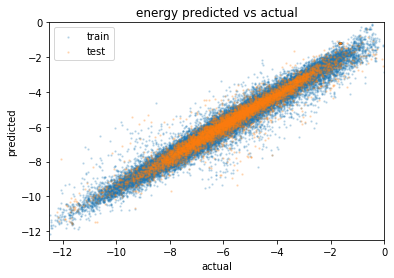

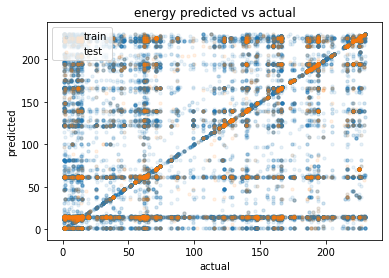

In [13]:
import matplotlib.pyplot as plt
#visualization of train and test prediction
## energy
predicted_energy_train = auto_model.predict(X_train)[1]
predicted_energy_test = auto_model.predict(X_test)[1]
plt.scatter(energy_train,predicted_energy_train,alpha=0.2,s=2)
plt.scatter(energy_test,predicted_energy_test,alpha =0.2,s=2)
plt.title('energy predicted vs actual')
plt.xlim(-12.5,0)
plt.ylim(-12.5,0)
plt.ylabel('predicted')
plt.xlabel('actual')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
## symmetry
symmetry_num_train = np.argmax(symmetry_train,axis=1)
predicted_symmetry_num_train = np.argmax(auto_model.predict(X_train)[0],axis=1)
symmetry_num_test = np.argmax(symmetry_test,axis=1)
predicted_symmetry_num_test = np.argmax(auto_model.predict(X_test)[0],axis=1)
plt.scatter(symmetry_num_train,predicted_symmetry_num_train,alpha=0.1,s=10)
plt.scatter(symmetry_num_test,predicted_symmetry_num_test,alpha =0.1,s=10)
plt.title('energy predicted vs actual')
plt.ylabel('predicted')
plt.xlabel('actual')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [14]:
#AutoKerasモデルの保存
Best_keras_model = auto_model.export_model()
Best_keras_model.save(f"./models/{model_name}.h5")

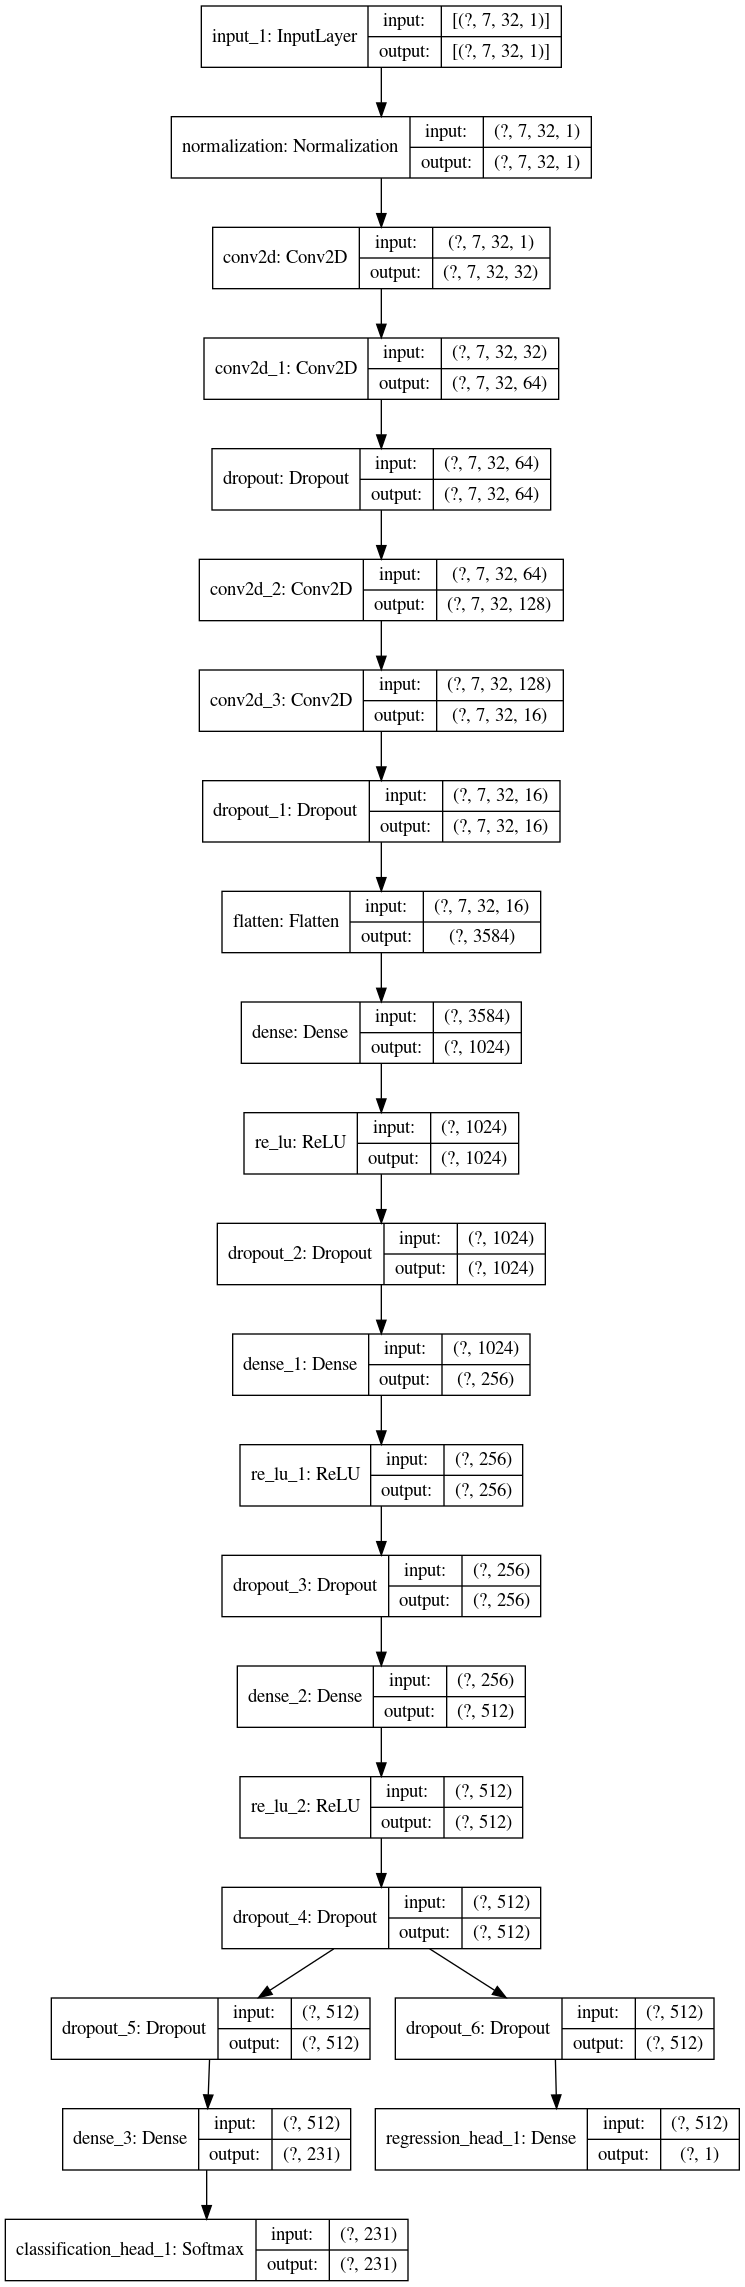

In [15]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import load_model
from IPython.display import Image

plot_model(Best_keras_model, to_file=f'./{model_name}.png', show_layer_names=True, show_shapes=True)
display(Image(f'{model_name}.png'))

In [16]:
#test with any composition
# auto_model= load_model("./models/201231_ES_custom_50ep_50try.h5")
compnames = []
compnames.append(compd.generate_extended_PT_from_composition("Li8O2Br3F").get_2d_array())
comp_np_array = np.array(compnames, dtype = np.float32)
stored_space_group = 0
spacegroup_num = 0
predicted_space_groups = auto_model.predict(comp_np_array.reshape(1,7,32))[0][0]
for i in range(230):
    if predicted_space_groups[i] > stored_space_group:
        second_spacegroup_num = spacegroup_num
        spacegroup_num = i
        second_space_group = stored_space_group
        stored_space_group = predicted_space_groups[i]
print(str(spacegroup_num) + ":" + str(stored_space_group))
print(str(second_spacegroup_num) + ":" + str(second_space_group))

221:0.15820195
123:0.09287495


In [21]:
#正式版の作成と保存
import tensorflow as tf

def reset_weights(model,weights=None):
    for layer in model.layers:
        print("---------------")
        print(layer)
        if isinstance(layer, tf.keras.Model): #if you're using a model as a layer
            reset_weights(layer) #apply function recursively
            continue
        if hasattr(layer, 'cell'):
            init_container = layer.cell
        else:
            init_container = layer

        for key, initializer in init_container.__dict__.items():
            if ("kernel_initializer" or "recurrent_initializer") not in key: #is this item an initializer?
                  continue #if no, skip it
            else:
                print("key:")
                print(key)
                print("initializer:")
                print(initializer)
                weights = layer.get_weights()
                weights = [initializer(w.shape, w.dtype) for w in weights] 
                layer.set_weights(weights)
from tensorflow.keras.models import load_model
loaded_model= load_model(f"./models/{model_name}.h5")
reset_weights(loaded_model)
#epoch optimization test
epoch_optimization_model = loaded_model.fit(X_train,[symmetry_train,energy_train],epochs=1000,validation_split=0.2)

# full_model = loaded_model.fit(X,[symmetry_category,dropped_seeddata["normalized_energy"]],epochs=50)

---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
key:
kernel_initializer
initializer:
Epoch 1/1000
1597/1597 [==============================] - 21s 13ms/step - loss: 6.1069 - classification_head_1_loss: 4.1517 - regression_head_1_loss: 1.9552 - classification_head_1_accuracy: 0.1295 - regression_head_1_mean_absolute_error: 0.9831 - val_loss: 4.1856 - val_classification_head_1_loss: 

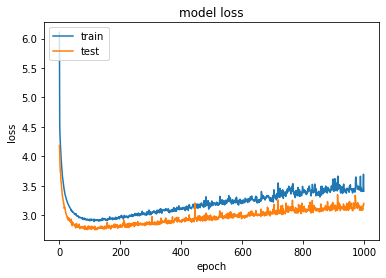

KeyError: 'acc'

In [22]:
import matplotlib.pyplot as plt
# 損失値をグラフ表示
history = epoch_optimization_model
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# 正解率をグラフ表示
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [30]:
#正式版の保存
loaded_model= load_model("./models/201231_ES_custom_50ep_50try.h5")
reset_weights(loaded_model)

release_model = loaded_model.fit(X,[symmetry_category,dropped_seeddata["normalized_energy"]],epochs=80)
loaded_model.save("./models/release/201231_ES_custom_80ep.h5")


---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
---------------
---------------
---------------
key:
kernel_initializer
initializer:
---------------
---------------
key:
kernel_initializer
initializer:
Epoch 1/80
2218/2218 [==============================] - 35s 16ms/step - loss: 5.9156 - classification_head_1_loss: 4.0028 - regression_head_1_loss: 1.9128 - classification_head_1_accuracy: 0.1513 - regression_head_1_mean_absolute_error: 0.9162
Ep